In [69]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
!pip install KDEpy
from KDEpy import FFTKDE,NaiveKDE
from sklearn import mixture
from sklearn.model_selection import GridSearchCV

# Задача 1

* **Загрузка данных**

In [47]:
data = pd.read_table('LakeHuron.txt')
X = np.sort(np.array(data['x']))

* **Оценка среднего и дисперсии ММП**
$$\mu = \overset{-}{X}$$
$$\sigma^2 = \overset{-}{X^2}-(\overset{-}{X})^2$$

In [48]:
mean = np.mean(X)
std = np.std(X)

* **Построение гистограммы**

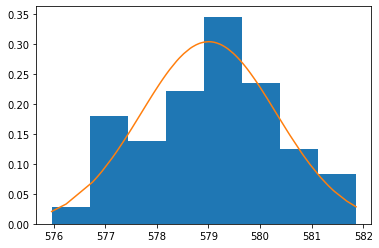

In [49]:
plt.hist(X,bins = 'sturges',density=True)
plt.plot(X,norm.pdf(X,loc = mean,scale = std));

* **Подбор оптимальной гистограммы**\
Для оценки гистограммы испольовалось:
$$\int Bias^2(\hat{p}_m(x))dx = \frac{h^2}{12}\int_{R}(p^{'}(x))^2dx = \frac{h^2}{48\sigma^3\sqrt{\pi}}$$
$$\int Var(\hat{p}_m(x))dx = \frac{1}{nh}$$
$$AMISE(\hat{p}_m(x)) = \int Bias^2(\hat{p}_m(x))dx+\int Var(\hat{p}_m(x))dx$$


In [50]:
def bv(h,n,sigma):
    bias = h**2/(48*sigma**3*np.sqrt(np.pi))
    var = 1/(n*h)
    return bias, var

In [51]:
nbins = np.arange(5,31)
bias,var = np.zeros_like(nbins,dtype=float),np.zeros_like(nbins,dtype=float)
for i,n in enumerate(nbins):
    vals, bins = np.histogram(X, bins=n, density=True)
    h = bins[1]-bins[0]
    bias[i],var[i] = bv(h,len(X),std)

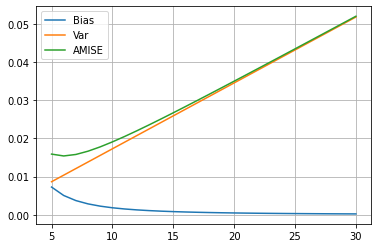

In [52]:
plt.plot(nbins,bias,label = 'Bias')
plt.plot(nbins,var,label = 'Var')
plt.plot(nbins,var+bias, label = 'AMISE')
plt.grid()
plt.legend();

* **Выбор лучшей оценки**

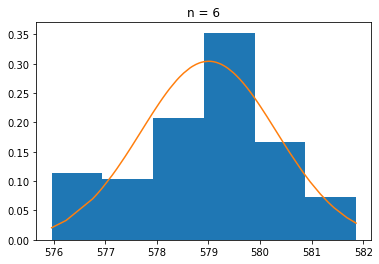

In [59]:
best_n = nbins[np.argmin(var+bias)]
plt.hist(X,bins = best_n,density=True)
plt.plot(X,norm.pdf(X,loc = mean,scale = std))
plt.title("n = {}".format(best_n));

* **Построение ядерных оценок с различными ядрами**

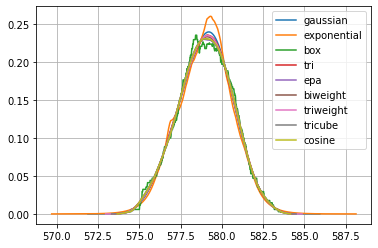

In [60]:
kernels = FFTKDE._available_kernels.keys()
for ker in kernels: 
    x, y = FFTKDE(kernel=ker).fit(X).evaluate()
    plt.plot(x,y,label = ker)
plt.grid()    
plt.legend();    

* **Построение ядерных оценок с различными методами выбора bandwidth**

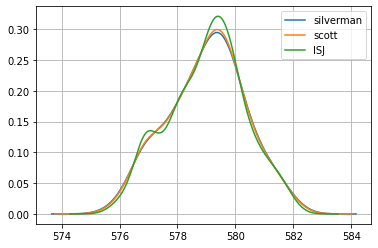

In [61]:
bws = FFTKDE._bw_methods.keys()
for bw in bws: 
    x, y = FFTKDE(kernel='gaussian',bw = bw).fit(X).evaluate()
    plt.plot(x,y,label = bw)
plt.grid()    
plt.legend();    

* **Визуализация лучших оценок**
1. Гистограмма: bins = 6
2. Ядерная оценка: kernel = 'gaussian', bw = 'silverman'


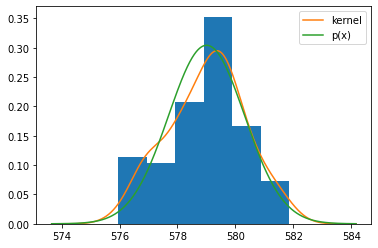

In [62]:
x, y = FFTKDE(kernel='gaussian',bw = 'silverman').fit(X).evaluate()
plt.hist(X,bins = 6,density=True)
plt.plot(x,y,label = 'kernel')
plt.plot(x,norm.pdf(x,loc = mean,scale = std),label = 'p(x)');
plt.legend();

# Задача 2

* **Вспомогательные функции**

In [29]:
# Плотность из условия
def pE(x):
    return stats.expon.pdf(x)
def pN(x):
    return stats.norm.pdf(x)
def p(x):
    return 1/2*pN(x)+1/4*pE(x+2)+1/4*pE(-x+2)

In [30]:
# Империческая MISE
def pn(x,vals,bins):
    left_edges = np.where(bins<=x)[0]
    if(len(left_edges)==0):
        return 0
    return vals[np.min(left_edges)]
def MISE(X,vals,bins):
    Q = 10000
    Xq = np.linspace(-3,3,num = Q)
    deviations = np.array([pn(x,vals,bins)-p(x) for x in Xq])
    return 6*np.mean(deviations**2)    

Случайная величина генерировалась следующим образом:
$$\nu = \begin{cases}1,p = \frac{1}{2}\\
                     2,p = \frac{1}{4}\\
                     3,p = \frac{1}{4}\end{cases} X = \ \begin{cases}X_1&,\nu = 1,X_1 \sim \Phi^N\\
                     X_2-2&,\nu = 2,X_2 \sim \Phi^E\\
                     2-X_3&,\nu = 3,X_3 \sim \Phi^E \end{cases}$$

In [31]:
# Генерация выборки размера N
def gen(N):
    nu = np.random.choice([1,2,3],size = N,p = [1/2,1/4,1/4])
    X = np.zeros(N)
    for i in range(N):
        if(nu[i] == 1):
            X[i] = np.random.normal(size = 1)
        elif(nu[i] == 2):
            X[i] = np.random.exponential(size = 1) - 2
        else:
            X[i] = -np.random.exponential(size = 1) + 2
    return X

* **Визуализация выборки**

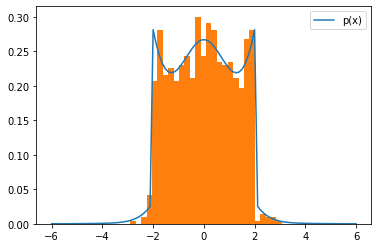

In [93]:
X = gen(1000)
grid = np.linspace(-6,6,100)
plt.plot(grid,[p(x) for x in grid],label = 'p(x)')
plt.hist(X,bins = 'stone',density=True)
plt.legend();

* **Оценка MISE для различных методов выбора количества столбцов**

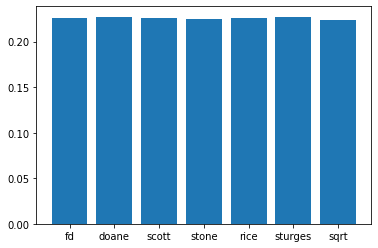

In [94]:
J = 20 
N = 1000
bws = ['fd', 'doane','scott', 'stone', 'rice', 'sturges','sqrt']
mise = {bw:np.zeros(J) for bw in bws}
for j in range(J):
    X = gen(N)
    for bw in bws:
        vals, bins = np.histogram(X, bins = bw, density=True)
        mise[bw][j] = MISE(X,vals,bins)
for bw in bws:
    mise[bw] = np.mean(mise[bw])  
plt.bar(bws,height=mise.values());     

* **Выбор лучшего метода**

In [99]:
best_bw = min(mise, key=mise.get)# Лучший метод: 'sqrt'
min_val = mise[best_bw]

* **Значения оценок оказались практически одинковыми, для визуального сравнения из них вычтена минимальная**

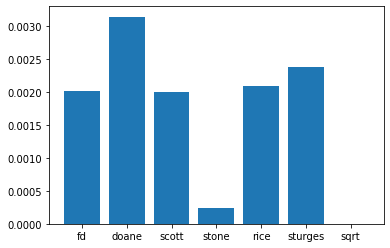

In [100]:
for key in mise.keys():
    mise[key] -= min_val
plt.bar(bws,height=mas.values());    

* **Построение ядреных оценок**

In [121]:
# Имперический MISE для ядерной оценки 
def MISE_KDE(X,kde):
    Q = 1000
    Xq = np.linspace(-3,3,num = Q)
    pns = np.array(kde.evaluate(Xq))
    ps = np.array([p(x) for x in Xq])
    return 6*np.mean((pns-ps)**2)    

In [122]:
bws = np.linspace(0.0001,1,num = 101,endpoint=False)
mise_kde = np.zeros_like(bws)
for j in range(J):
    X = gen(1000)
    for i,bw in enumerate(bws):
        kde = NaiveKDE(kernel='epa',bw = bw).fit(X)
        mise_kde[i] += MISE_KDE(X,kde)
mise_kde/=J            

* **Визуализация MISE**

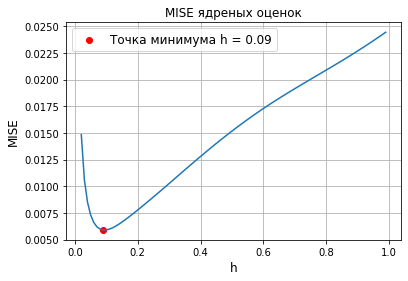

In [123]:
min_id = np.argmin(mise_kde)
h_min = bws[min_id]
plt.plot(bws[2:],mise_kde[2:])
plt.scatter(h_min,mise_kde[min_id],c='r',label = 'Точка минимума h = {:.2f}'.format(h_min))
plt.grid()
plt.title("MISE ядреных оценок",fontsize = 12)
plt.ylabel('MISE',fontsize = 12)
plt.xlabel('h',fontsize = 12)
plt.legend(fontsize = 12);

* **Построение лучших оценок**

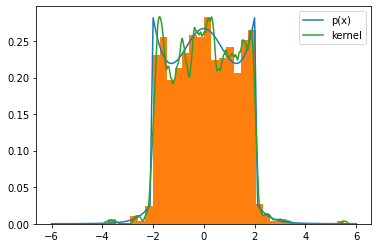

In [129]:
X = gen(1000)
grid = np.linspace(-6,6,100)
x,y = kde = NaiveKDE(kernel='epa',bw = h_min).fit(X).evaluate()
plt.plot(grid,[p(x) for x in grid],label = 'p(x)')
plt.hist(X,bins = 'sqrt',density=True)
plt.plot(x,y,label = 'kernel')
plt.legend();

# Задание 3

* **Вспомогательные функции**

In [192]:
# Генерация выборки из распределения Барта Симпсона размера N
def gen_BS(N):
    nu = np.random.choice(np.arange(6),size = N,p = [1/2,1/10,1/10,1/10,1/10,1/10])
    X = np.zeros(N)
    for i in range(N):
        if(nu[i] == 0):
            X[i] = np.random.normal(size=1)
        else:
            X[i] = np.random.normal(loc=(nu[i]-1)/2-1, scale=1/10, size=1)
    return np.sort(X).reshape(-1,1)

In [193]:
# Истинная плотность
def p(x):
    return 1/2*stats.norm.pdf(x)+1/10*np.sum(np.array([stats.norm.pdf(x,loc=j/2-1, scale=1/10) for j in range(5)]))

In [194]:
# Выбор лучшей ядерной оценки
def get_model_id(X,p_EM,p_K):
    error = dict()
    for n in p_EM.keys():
        error[n] = np.sum((p_EM[n]-p_K)**2)
    return min(error,key = error.get)

* **Генерация выборки**

In [195]:
N = 1000
X = gen_BS(N)

* **Построение оценок** 

In [196]:
n_components = np.arange(2,11)
estimators = dict()
loglikelihood = dict()
p_EM = dict()
for n in n_components:
    estimator = mixture.GaussianMixture(n_components = n).fit(X)
    pdf_est = np.exp(estimator.score_samples(X))
    resp = estimator.predict_proba(X)
    p_EM[n] = np.sum(resp*pdf_est[:, np.newaxis],axis = 1)
    estimators[n] = estimator
    loglikelihood[n] = estimator.score(X)

* **Выбор оценки с максимальным значением функции правдоподобия**

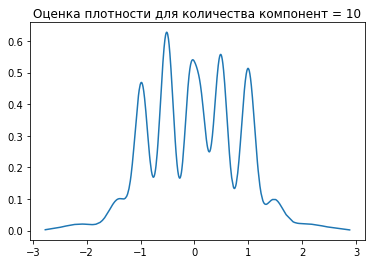

In [197]:
best_n = max(loglikelihood,key = loglikelihood.get)
best_estimator = estimators[best_n]
plt.plot(X,p_EM[best_n])
plt.title('Оценка плотности для количества компонент = {}'.format(best_n));

* **Построение ядреной оценки** 

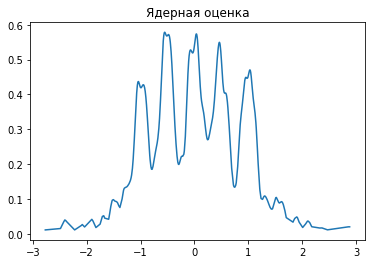

In [198]:
p_K = NaiveKDE(kernel='gaussian',bw = 'ISJ').fit(X).evaluate(X)
plt.plot(X,p_K)
plt.title("Ядерная оценка");

* **Выбор EM оценки, наиболее близкой к ядерной**

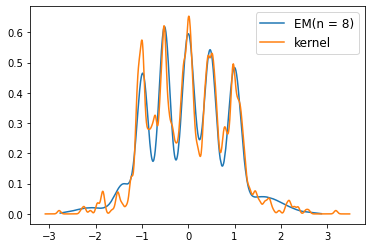

In [200]:
best_model = get_model_id(X,p_EM,p_K)
plt.plot(X,p_EM[best_model],label = 'EM(n = {})'.format(best_model))
plt.plot(x,y,label = 'kernel')
plt.legend(fontsize = 12);

In [71]:
import os

from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive/')
clear_output()

WORKDIR = '/content/drive/My Drive/knn'  # your working dir in Google Drive
NB_NAME = 'Statisitcs2'                        # your notebook name

!jupyter nbconvert --to html "{WORKDIR}/{NB_NAME}.ipynb" \
                   --output  "{WORKDIR}/{NB_NAME}.html"

[NbConvertApp] Converting notebook /content/drive/My Drive/knn/Statisitcs2.ipynb to html
[NbConvertApp] Writing 612890 bytes to /content/drive/My Drive/knn/Statisitcs2.html
